In [112]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [113]:
df = pd.read_csv("monthly_features.csv", parse_dates=["Date"], index_col="Date").sort_index()

In [114]:
df.head()

,Month_start,Month_end,High,Low,Year,Return_prev_month,Volatility_prev_month,Range_prev_month,MA5d_minus_MA20d,MA3m,...,February,January,July,June,March,May,November,October,September,Label_next_month
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-31,2108.29,2107.39,2130.82,2080.15,2015,-0.000427,0.006810,50.67,4.4405,2086.930000,...,False,False,False,False,False,True,False,False,False,-0.023024
2015-06-30,2111.73,2063.11,2124.20,2057.64,2015,-0.023024,0.007012,66.56,-11.5195,2085.336667,...,False,False,False,True,False,False,False,False,False,0.012718
2015-07-31,2077.42,2103.84,2128.28,2046.68,2015,0.012718,0.007372,81.60,0.5380,2091.446667,...,False,False,True,False,False,False,False,False,False,-0.059989
2015-08-31,2098.04,1972.18,2104.18,1867.61,2015,-0.059989,0.016831,236.57,-85.5915,2046.376667,...,False,False,False,False,False,False,False,False,False,0.003229
2015-09-30,1913.85,1920.03,1995.31,1881.77,2015,0.003229,0.014185,113.54,-36.0360,1998.683333,...,False,False,False,False,False,False,False,False,True,0.080850


In [115]:
feature_cols = [c for c in df.columns if c != "Label_next_month"]

In [116]:
feat = df[feature_cols].values.astype(np.float32)             
labels = df["Label_next_month"].values.astype(np.float32)   

In [117]:
lookback = 12
X_list, y_list = [], []
for t in range(lookback - 1, len(df)):
    X_list.append(feat[t - lookback + 1 : t + 1, :])  # (T,F)
    y_list.append([labels[t]])                        # (1,)
X_all = np.stack(X_list).astype(np.float32)           # (N, T, F)
y_all = np.stack(y_list).astype(np.float32)           # (N, 1)
N, T, F = X_all.shape
print(f"N={N}, T={T}, F={F}")

N=104, T=12, F=24


In [118]:
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

X_train = X_all[:n_train]
y_train = y_all[:n_train]
X_val   = X_all[n_train:n_train+n_val]
y_val   = y_all[n_train:n_train+n_val]
X_test  = X_all[n_train+n_val:]
y_test  = y_all[n_train+n_val:]

In [119]:
scaler = StandardScaler()
Xtr2 = X_train.reshape(-1, F)
scaler.fit(Xtr2)

def scale_3d(X3):
    X2 = X3.reshape(-1, F)
    X2 = scaler.transform(X2)
    return X2.reshape(X3.shape)

X_train = scale_3d(X_train)
X_val   = scale_3d(X_val)
X_test  = scale_3d(X_test)

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim

In [121]:
torch.manual_seed(0)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)


In [122]:
hidden_size = 32
lstm = nn.LSTM(input_size=F, hidden_size=hidden_size, batch_first=True)
head = nn.Linear(hidden_size, 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(lstm.parameters()) + list(head.parameters()), lr=1e-3)

def predict(X):
    out, _ = lstm(X)            # (B,T,H)
    return head(out[:, -1, :])  # (B,1)

In [123]:
epochs = 300
for ep in range(1, epochs + 1):
    lstm.train(); head.train()
    pred_tr = predict(X_train)
    loss_tr = criterion(pred_tr, y_train)

    optimizer.zero_grad()
    loss_tr.backward()
    optimizer.step()

    lstm.eval(); head.eval()
    with torch.no_grad():
        pred_val = predict(X_val)
        loss_val = criterion(pred_val, y_val)

    if ep % 10 == 0 or ep == 1 or ep == epochs:
        print(f"Epoch {ep:03d} | train MSE={loss_tr.item():.6f} | val MSE={loss_val.item():.6f}")


Epoch 001 | train MSE=0.009723 | val MSE=0.012644
Epoch 010 | train MSE=0.003079 | val MSE=0.004753
Epoch 020 | train MSE=0.001739 | val MSE=0.004255
Epoch 030 | train MSE=0.001157 | val MSE=0.004067
Epoch 040 | train MSE=0.000867 | val MSE=0.003540
Epoch 050 | train MSE=0.000668 | val MSE=0.003556
Epoch 060 | train MSE=0.000527 | val MSE=0.003696
Epoch 070 | train MSE=0.000429 | val MSE=0.003649
Epoch 080 | train MSE=0.000355 | val MSE=0.003341
Epoch 090 | train MSE=0.000297 | val MSE=0.003301
Epoch 100 | train MSE=0.000249 | val MSE=0.003157
Epoch 110 | train MSE=0.000209 | val MSE=0.003089
Epoch 120 | train MSE=0.000177 | val MSE=0.003032
Epoch 130 | train MSE=0.000149 | val MSE=0.002991
Epoch 140 | train MSE=0.000126 | val MSE=0.002988
Epoch 150 | train MSE=0.000107 | val MSE=0.003007
Epoch 160 | train MSE=0.000092 | val MSE=0.003047
Epoch 170 | train MSE=0.000078 | val MSE=0.003103
Epoch 180 | train MSE=0.000067 | val MSE=0.003171
Epoch 190 | train MSE=0.000057 | val MSE=0.003247


In [124]:
lstm.eval(); head.eval()
with torch.no_grad():
    pred_te = predict(X_test)
    test_mse = criterion(pred_te, y_test).item()
    test_mae = torch.mean(torch.abs(pred_te - y_test)).item()
print(f"TEST | MSE={test_mse:.6f} | MAE={test_mae:.6f}")

TEST | MSE=0.003220 | MAE=0.043698


In [125]:
with torch.no_grad():
    pred_next = predict(X_test[-1:].float()).item()
print("Predicted next-month return (last window):", pred_next)

Predicted next-month return (last window): 0.05636684224009514


In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [128]:
with torch.no_grad():
    y_pred = predict(X_test).squeeze(-1).cpu().numpy()  # (n_test,)
y_true = y_test.squeeze(-1).cpu().numpy()               # (n_test,)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"TEST metrics -> MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

TEST metrics -> MSE: 0.003220 | MAE: 0.043698 | R²: -1.6725


In [129]:
window_end_indices = np.arange(lookback - 1, len(df))
test_end_indices = window_end_indices[-len(y_true):]
test_dates = df.index[test_end_indices]  # DatetimeIndex，与 y_true/y_pred 对齐

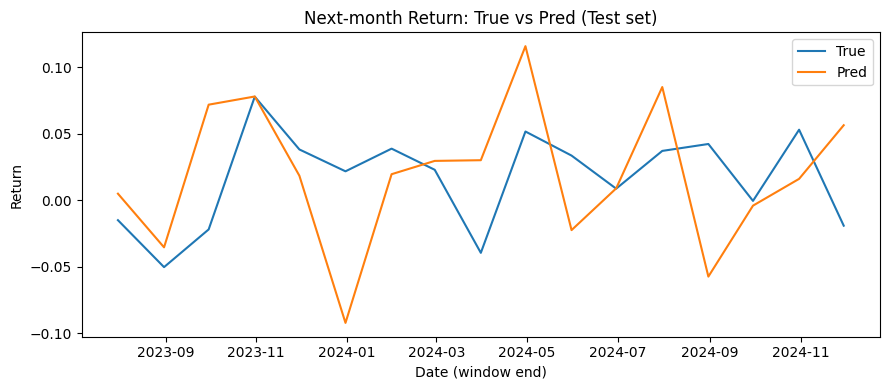

In [130]:
plt.figure(figsize=(9, 4))
plt.plot(test_dates, y_true, label="True")
plt.plot(test_dates, y_pred, label="Pred")
plt.title("Next-month Return: True vs Pred (Test set)")
plt.xlabel("Date (window end)")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()


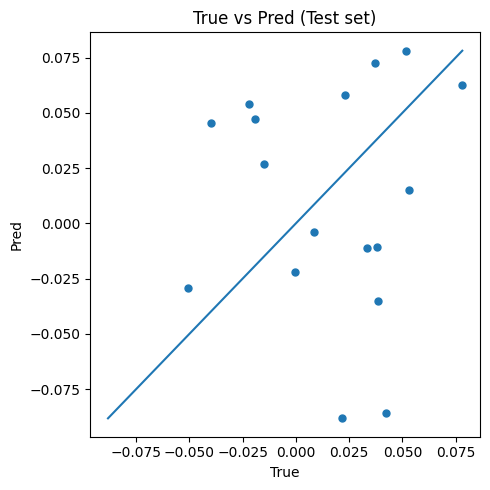

In [57]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=25)
xymin = min(float(y_true.min()), float(y_pred.min()))
xymax = max(float(y_true.max()), float(y_pred.max()))
plt.plot([xymin, xymax], [xymin, xymax])  # y = x 参考线
plt.title("True vs Pred (Test set)")
plt.xlabel("True")
plt.ylabel("Pred")
plt.tight_layout()
plt.show()

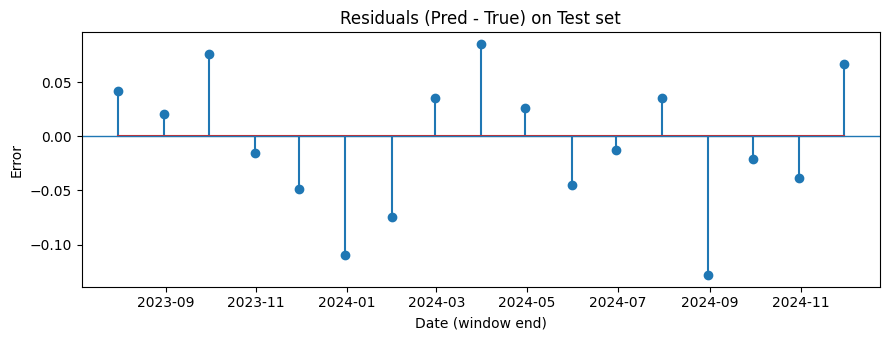

In [59]:
residuals = y_pred - y_true
plt.figure(figsize=(9, 3.5))
plt.stem(test_dates, residuals)
plt.axhline(0, linewidth=1)
plt.title("Residuals (Pred - True) on Test set")
plt.xlabel("Date (window end)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

In [131]:
np.mean((y_pred > 0) == (y_true > 0))

np.float64(0.5882352941176471)

In [132]:
y_pred_prev = df.loc[test_dates, "Return_prev_month"].to_numpy()

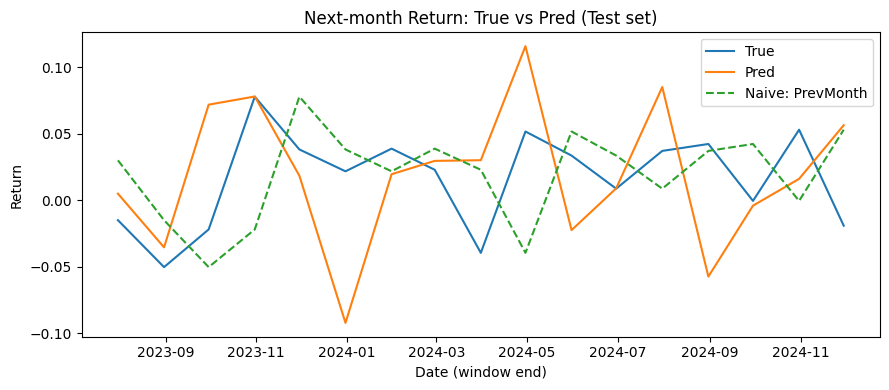

In [133]:
plt.figure(figsize=(9, 4))
plt.plot(test_dates, y_true, label="True")
plt.plot(test_dates, y_pred, label="Pred")
plt.plot(test_dates, y_pred_prev, linestyle="--", label="Naive: PrevMonth")  # 天真预测
plt.title("Next-month Return: True vs Pred (Test set)")
plt.xlabel("Date (window end)")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

                 MSE     RMSE      MAE        R2   DirAcc
LSTM        0.003220 0.056748 0.043698 -1.672527 0.588235
Naive(prev) 0.002377 0.048752 0.040992 -0.972431 0.588235


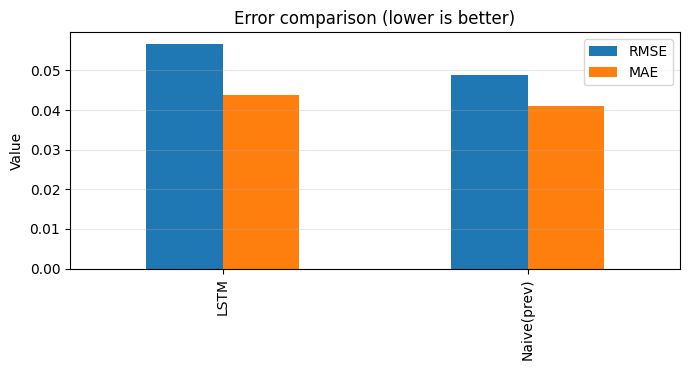

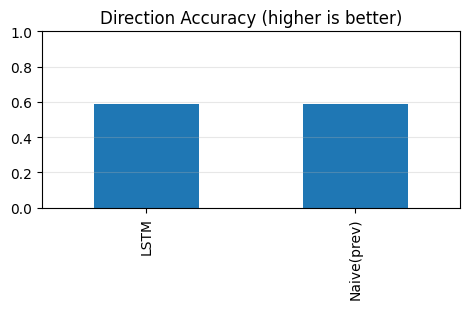

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 假设你已有：
# y_true  -> 测试集真实值，shape (n_test,)
# y_pred  -> LSTM 的预测，shape (n_test,)
# test_dates -> 与 y_true 对齐的日期索引（窗口末月）
# df      -> 原始 DataFrame，含列 'Return_prev_month'

# 1) 天真预测：上月收益（与测试日期对齐）
y_pred_naive = df.loc[test_dates, "Return_prev_month"].to_numpy()

# 2) 评估函数
def eval_metrics(y_true, y_hat):
    y_true = np.asarray(y_true).ravel()
    y_hat  = np.asarray(y_hat).ravel()
    mse  = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_hat))  # 方向准确率
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "DirAcc": dir_acc}

# 3) 计算并展示
res = pd.DataFrame({
    "LSTM":  eval_metrics(y_true, y_pred),
    "Naive(prev)": eval_metrics(y_true, y_pred_naive),
}).T  # 行=模型，列=指标

# 更易读的打印
print(res.to_string(float_format=lambda x: f"{x:.6f}"))

# 4) 简单可视化（误差类越低越好；R2/DirAcc 越高越好）
fig, ax = plt.subplots(1, 1, figsize=(7, 3.8))
bars = res[["RMSE","MAE"]]
bars.plot(kind="bar", ax=ax)
ax.set_title("Error comparison (lower is better)")
ax.set_ylabel("Value")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 方向准确率对比
fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.2))
res["DirAcc"].plot(kind="bar", ax=ax)
ax.set_ylim(0, 1)
ax.set_title("Direction Accuracy (higher is better)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()